In [ ]:
import torch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!pip install opencv-python matplotlib

import requests
import tarfile
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:


!pip install opencv-python matplotlib

import requests
import tarfile
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("dataset/images", exist_ok=True)
os.makedirs("dataset/masks", exist_ok=True)
os.makedirs("scripts")

DATASET_PATH = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
ANNOTATIONS_PATH ="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
ROOT_DIR = Path("dataset")
IMAGE_DIR = ROOT_DIR / "images"
MASKS_DIR = ROOT_DIR / "masks"

ROOT_DIR.mkdir(exist_ok=True)

def download_and_extract(url, dest):
    """
    Downloads and extracts a .tar.gz file from a URL into the given destination folder.

    Parameters:
        url (str): The URL of the .tar.gz file to download.
        dest (Path or str): The destination directory to extract the contents into.
    """
    dest = Path(dest)
    dest.mkdir(parents=True, exist_ok=True)

    # Get filename from URL (e.g., images.tar.gz)
    fname = url.split("/")[-1]
    target_folder_name = fname.replace(".tar.gz", "")
    target_path = dest / target_folder_name

    # If folder already extracted, skip
    if target_path.exists() and any(target_path.iterdir()):
        print(f"{target_folder_name}/ already exists — skipping download.")
        return

    print(f"Downloading {fname} from {url}...")
    response = requests.get(url, stream=True)
    with open(fname, 'wb') as f:
        f.write(response.content)

    print(f"Extracting {fname} into {dest}/ ...")
    with tarfile.open(fname, "r:gz") as tar:
        tar.extractall(path=dest)

    os.remove(fname)
    print(f"{fname} download and extraction complete.")

def convert_masks():
  #1. Set the path where  the original masks lie
  seg_dir = ROOT_DIR / "annotations" / "trimaps"
  #2. Make sure that the directory where the images will be saved exists
  MASKS_DIR.mkdir(exist_ok=True)
  #3. Iterate through all the images in the .png masks files
  for images in seg_dir.glob("*.png"):
    #4.1 Check if the file is a hidden system file starting with "._"
    #    If it is, skip processing this file.
    if images.name.startswith("._"):
        continue
    #4.2 Opening the Images using the PIL(Python Imaging Library)
    img = Image.open(images)
    #5. Converting the Image to numpy array so that we can manipulate the values easily
    img = np.array(img)
    #6. Original masks has labels 1:pet , 2:border, 3: background
    #   We subtract 1 from everything and make it 0-based
    #   Now its 0:pet, 1:border, 2:background
    img = img-1
    #7. Re-checking that there are no negative pixel values, if any pixel<0, we make
    #   it 0 i.e. background
    img[img<0] = 0
    #8. We convert the dtype to uint8 so that pixel values are 0-255, then convert it back
    #   to Image format and save it in the required path
    Image.fromarray(img.astype(np.uint8)).save(MASKS_DIR / images.name)

def main():
  if not IMAGE_DIR.exists() or len(os.listdir(IMAGE_DIR)) == 0:
        download_and_extract(DATASET_PATH, ROOT_DIR)
  if not (ROOT_DIR / "annotations").exists() or len(os.listdir((ROOT_DIR / "annotations"))) == 0:
        download_and_extract(ANNOTATIONS_PATH, ROOT_DIR)
  convert_masks()

if __name__ == "__main__":
    main()



Extracting images.tar.gz into dataset/ ...
images.tar.gz download and extraction complete.
Extracting annotations.tar.gz into dataset/ ...
annotations.tar.gz download and extraction complete.


Contents of dataset/: ['annotations', 'images', 'masks']
Images in dataset/images/: ['boxer_186.jpg', 'english_cocker_spaniel_121.jpg', 'boxer_41.jpg', 'Ragdoll_130.jpg', 'beagle_49.jpg']


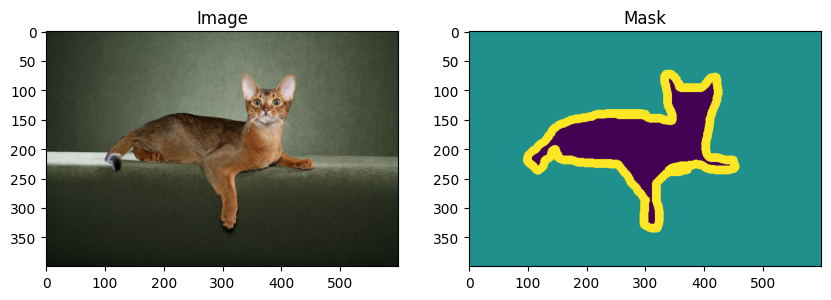

In [ ]:
import os
print("Contents of dataset/:", os.listdir("dataset"))
print("Images in dataset/images/:", os.listdir("dataset/images")[:5])  # show first 5 images

img = Image.open("/content/dataset/images/Abyssinian_1.jpg")
masks = Image.open("/content/dataset/masks/Abyssinian_1.png")

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(img)

plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(masks)



In [ ]:
"""##**Task 2 Utility Functions**"""
!pip install torch torchvision matplotlib opencv-python

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn


#Dataset Class
class Pet_Dataset(Dataset):
  def __init__(self, image_dir, mask_dir, size=(128,128)):
      self.image_dir = image_dir
      self.mask_dir = mask_dir
      self.image_transforms = T.Compose([
          T.Resize(size),
          T.ToTensor()
      ])
      self.size = size
      self.images = sorted([f for f in os.listdir(self.image_dir) if f.endswith(".jpg")])
      self.mask_transforms = T.Compose([
          T.Resize(size, interpolation=Image.NEAREST),
          T.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
      ])
  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
      image_name = self.images[index]
      image_path = os.path.join(self.image_dir, image_name)
      mask_path = os.path.join(self.mask_dir, image_name.replace(".jpg",".png"))
      image = Image.open(image_path).convert("RGB")
      mask = Image.open(mask_path)

      image = self.image_transforms(image)
      mask = self.mask_transforms(mask)

      return image,mask
# Defining the Model
class UNet(nn.Module):
  def __init__(self,n_classes):
    super(UNet,self).__init__()
    def CBR(in_channels,out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
          nn.ReLU()
      )
    self.enc1 = CBR(3,64)
    self.enc2 = CBR(64,128)
    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    self.up = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
    self.dec1 = nn.Conv2d(128,64,kernel_size=3,padding=1)
    self.final = nn.Conv2d(64,n_classes,1)

  def forward(self, x):
    e1 = self.enc1(x)
    # print(f"Shape e1:{e1.shape}")
    e2 = self.enc2(self.pool(e1))
    # print(f"Shape e2:{e2.shape}")

    d1 = self.up(e2)
    # print(f"Shape after passing up layer:{d1.shape}")
    d1 = torch.cat([d1,e1],dim=1)
    # print(f"Shape after concatenation:{d1.shape}")
    d1 = self.dec1(d1)
    # print(f"Shape passing decoder layer:{d1.shape}")
    return self.final(d1)

#Metrics

def compute_iou(pred, target, n_classes=3):
  ious = []
  pred = pred.view(-1)
  target = target.view(-1)

  for cls in range(n_classes):
    pred_indices = (pred == cls)
    target_indices = (target == cls)
    intersection = (pred_indices & target_indices).sum().item()
    union = (pred_indices | target_indices).sum().item()
    if union == 0:
      ious.append(float('nan'))
    else:
      ious.append(intersection/union)

  return ious
def pixel_accuracy(pred, target):
  correct = (pred == target).sum().item()
  total = target.numel()
  return correct/total
def dice_score(pred, target, n_classes=3):
  dice = []

  for cls in range(n_classes):
    pred_cls = (pred == cls).float()
    target_cls = (target == cls).float()
    intersection = (pred_cls * target_cls).sum()
    union = pred_cls.sum() + target_cls.sum()
    if union == 0:
      dice.append(float('nan'))
    else:
      dice.append((2. * intersection)/union)

  return dice
# Function for evaluating model on a given dataset
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_targets.append(masks.cpu())

    preds_all = torch.cat(all_preds, dim=0)
    targets_all = torch.cat(all_targets, dim=0)

    ious = compute_iou(preds_all, targets_all)
    dices = dice_score(preds_all, targets_all)
    acc = pixel_accuracy(preds_all, targets_all)

    return ious, dices, acc, preds_all, targets_all

# 🖼️ Log one sample from validation
    def mask_to_rgb(mask_tensor):
        mask = mask_tensor.numpy()
        colors = np.array([[0, 0, 0], [255, 0, 0], [0, 255, 0]])
        return colors[mask]


Train dataset size: 5173
Validation dataset size: 1108
Test dataset size: 1109


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch 1, Train Loss: 0.8969
Val Pixel Accuracy: 0.6302
Val IoU: [0.30678601570590425, 0.6135849056603774, 0.026810462517440334]
Val Dice: [tensor(0.4695), tensor(0.7605), tensor(0.0522)]
Epoch 2, Train Loss: 0.7813
Val Pixel Accuracy: 0.6821
Val IoU: [0.3665438698524898, 0.6555444234501583, 0.07742225648933436]
Val Dice: [tensor(0.5365), tensor(0.7919), tensor(0.1437)]
Epoch 3, Train Loss: 0.7079
Val Pixel Accuracy: 0.7163
Val IoU: [0.464455966818348, 0.6868027431845523, 0.1499560198725317]
Val Dice: [tensor(0.6343), tensor(0.8143), tensor(0.2608)]
Epoch 4, Train Loss: 0.6840
Val Pixel Accuracy: 0.7148
Val IoU: [0.5023598219035765, 0.673093517691811, 0.2122112510066384]
Val Dice: [tensor(0.6688), tensor(0.8046), tensor(0.3501)]
Epoch 5, Train Loss: 0.6690
Val Pixel Accuracy: 0.7187
Val IoU: [0.46004098801460713, 0.6895768265524794, 0.1285307008069634]
Val Dice: [tensor(0.6302), tensor(0.8163), tensor(0.2278)]
Epoch 6, Train Loss: 0.6729
Val Pixel Accuracy: 0.7291
Val IoU: [0.4657608291

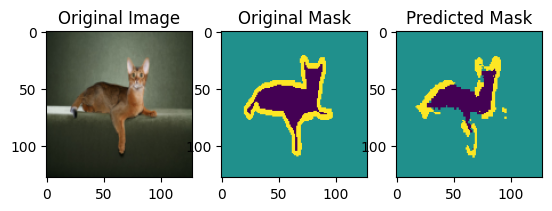

In [ ]:
"""##**Task 2**"""
def main1():
  ROOT_DIR = Path("dataset")
  IMAGE_DIR = ROOT_DIR / "images"
  MASKS_DIR = ROOT_DIR / "masks"

  dataset = Pet_Dataset(IMAGE_DIR, MASKS_DIR)

  import torch
  from torch.utils.data import random_split

  # Assuming 'dataset' is already defined as Pet_Dataset(IMAGE_DIR, MASKS_DIR)

  # Define the split ratios
  train_ratio = 0.7
  val_ratio = 0.15
  test_ratio = 0.15

  # Calculate the sizes of each split
  dataset_size = len(dataset)
  train_size = int(train_ratio * dataset_size)
  val_size = int(val_ratio * dataset_size)
  test_size = dataset_size - train_size - val_size

  # Split the dataset
  train_dataset, val_dataset, test_dataset = random_split(
      dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
  )

  # Print the sizes of each split
  print(f"Train dataset size: {len(train_dataset)}")
  print(f"Validation dataset size: {len(val_dataset)}")
  print(f"Test dataset size: {len(test_dataset)}")

  train_loader = DataLoader(
      dataset=train_dataset,
      batch_size=8,
      shuffle=True
  )

  val_loader = DataLoader(
      dataset=val_dataset,
      batch_size=8,
      shuffle=False
  )

  test_loader = DataLoader(
      dataset=test_dataset,
      batch_size=8,
      shuffle=True
  )

  device = "cuda" if torch.cuda.is_available() else "cpu"
  device

  model = UNet(n_classes=3).to(device)

  optimizer = torch.optim.Adam(model.parameters(),
                              lr=0.01)
  loss_fn = nn.CrossEntropyLoss()



  !pip install wandb

  import wandb
  wandb.login()
  wandb.init(
      project="oxford-pet-segmentation",
      name="unet-128x128-split",
      config={
          "epochs": 15,
          "batch_size": 8,
          "image_size": "128x128",
          "architecture": "UNet",
          "loss": "CrossEntropy",
          "optimizer": "Adam",
          "learning_rate": 1e-3,
          "num_classes": 3,
      }
  )
  for epoch in range(wandb.config.epochs):
      model.train()
      train_loss = 0.0

      for images, masks in train_loader:
          images, masks = images.to(device), masks.to(device)

          preds = model(images)
          loss = loss_fn(preds, masks)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
      train_loss/=len(train_loader)

      print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

      # 🎯 Validation Step
      ious, dices, acc, val_preds, val_targets = evaluate_model(model, val_loader, device)

      print(f"Val Pixel Accuracy: {acc:.4f}")
      print(f"Val IoU: {ious}")
      print(f"Val Dice: {dices}")

      # 🟩 WandB Logging
      wandb.log({
          "epoch": epoch + 1,
          "train_loss": train_loss,
          "val_pixel_accuracy": acc,
          "val_iou_class_0": ious[0],
          "val_iou_class_1": ious[1],
          "val_iou_class_2": ious[2],
          "val_dice_class_0": dices[0],
          "val_dice_class_1": dices[1],
          "val_dice_class_2": dices[2],
      })


      # 🖼️ Log one sample from validation
      def mask_to_rgb(mask_tensor):
          mask = mask_tensor.numpy()
          colors = np.array([[0, 0, 0], [255, 0, 0], [0, 255, 0]])
          return colors[mask]


      val_sample_image, val_sample_mask = next(iter(val_loader))
      val_sample_image = val_sample_image[0].to(device).unsqueeze(0)
      val_pred = torch.argmax(model(val_sample_image), dim=1).squeeze().cpu()
      val_image = val_sample_image.squeeze().permute(1, 2, 0).cpu().numpy()
      val_true = val_sample_mask[0]

      wandb.log({
          "Val/Input": wandb.Image(val_image, caption="Input"),
          "Val/Prediction": wandb.Image(mask_to_rgb(val_pred), caption="Prediction"),
          "Val/True Mask": wandb.Image(mask_to_rgb(val_true), caption="Ground Truth")
      })

  print("🔍 Running final evaluation on test set...")
  test_ious, test_dices, test_acc, _, _ = evaluate_model(model, test_loader, device)

  print(f"Test Accuracy: {test_acc:.4f}")
  print(f"Test IoU: {test_ious}")
  print(f"Test Dice: {test_dices}")

  wandb.log({
      "test_pixel_accuracy": test_acc,
      "test_iou_class_0": test_ious[0],
      "test_iou_class_1": test_ious[1],
      "test_iou_class_2": test_ious[2],
      "test_dice_class_0": test_dices[0],
      "test_dice_class_1": test_dices[1],
      "test_dice_class_2": test_dices[2],
  })

  #7. Predictions
  model.eval()
  with torch.inference_mode():
    sample_img, sample_mask = dataset[0]
    pred1 = model(sample_img.unsqueeze(0).to(device))
    pred = torch.argmax(pred1.squeeze(0),dim=0).cpu().numpy()
  plt.subplot(1,3,1)
  plt.imshow(sample_img.permute(1,2,0))
  plt.title("Original Image")
  plt.subplot(1,3,2)
  plt.imshow(sample_mask)
  plt.title("Original Mask")
  plt.subplot(1,3,3)
  plt.imshow(pred)
  plt.title("Predicted Mask")

  # Convert the tensors to PIL images
  original_image = T.ToPILImage()(sample_img)
  original_mask = Image.fromarray(sample_mask.numpy().astype(np.uint8))
  predicted_mask = Image.fromarray(pred.astype(np.uint8))

  # Save the images
  original_image.save("original_image.jpg")
  original_mask.save("original_mask.png")
  predicted_mask.save("predicted_mask.png")


if __name__ == "__main__":
  main1()

